Reference: 
1. https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
2. https://www.tensorflow.org/tutorials/generative/dcgan     
3. https://github.com/christianversloot/machine-learning-articles/blob/main/creating-dcgan-with-tensorflow-2-and-keras.md 
4. https://towardsdatascience.com/developing-a-dcgan-model-in-tensorflow-2-0-396bc1a101b2 

In [2]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
import time
import json

from IPython import display

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# generate the seed to start the generator
num_examples = 16
dim_noise = 100
seed = tf.random.normal([num_examples,dim_noise])

In [42]:
class DCGAN_model_celeb():
    
    def __init__(self,
                batch_size=32,
                dropout=0.3,
                kernel_size=(5,5),
                lr_generator=2e-4,
                lr_discriminator=2e-4,
                beta_1_generator=0.5,
                beta_1_dicriminator=0.5,
                folder_prefix="DCGAN",
                third_disc_layer=False):
        self.batch_size = batch_size
        # some parameters needed in the generator and discriminator
        self.dropout = dropout
        self.dense_width = 4     #the dense width of noise to first layer in generator
        self.dense_depth = 1024   #the dense depth of noise to first layer in generator
        self.dense_size = self.dense_width * self.dense_width * self.dense_depth   #dense to this size in the first layer in generator
        self.kernel_size = kernel_size
        self.strides_size = 2
        self.strides = (self.strides_size, self.strides_size)

        # for ADAM optimizer
        self.lr_generator=lr_generator
        self.lr_discriminator=lr_discriminator
        self.beta_1_generator=beta_1_generator
        self.beta_1_dicriminator=beta_1_dicriminator
        beta_2=0.999
        epsilon=1e-07
        
        self.folder_name = folder_prefix + "_bs{}_dr{}_ks{}_lrg{}_lrd{}_b1g{}_b1d{}_tdl{}".format(batch_size,
                                                                                           dropout,
                                                                                           kernel_size,
                                                                                           lr_generator,
                                                                                           lr_discriminator,
                                                                                           beta_1_generator,
                                                                                           beta_1_dicriminator,
                                                                                           third_disc_layer)
        
        self.loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        
        self.generator = self.init_generator()
        self.discriminator = self.init_discriminator()
        
        self.generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_generator,
                                           beta_1=beta_1_generator,
                                           beta_2=beta_2,
                                           epsilon=epsilon)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_discriminator,
                                           beta_1=beta_1_dicriminator,
                                           beta_2=beta_2,
                                           epsilon=epsilon)
        
    @tf.function
    def train_step(self, images):
        noise = tf.random.normal([self.batch_size, dim_noise])
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real = self.discriminator(images, training=True)
            gen_out = self.discriminator(generated_images, training=True)

            gen_loss_step = self.gen_loss(gen_out)
            disc_loss_step = self.dis_loss(real, gen_out)

        grad_gen = gen_tape.gradient(gen_loss_step, self.generator.trainable_variables)
        grad_dis = disc_tape.gradient(disc_loss_step, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(grad_gen, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(grad_dis, self.discriminator.trainable_variables))
        
    def epoch_losses(self, test_dataset):
        gen_losses = []
        disc_losses = []
        for image_batch in test_dataset:
            noise = tf.random.normal([self.batch_size, dim_noise])
            generated_images = self.generator(noise, training=False)

            real = self.discriminator(image_batch, training=False)
            gen_out = self.discriminator(generated_images, training=False)

            gen_losses.append(self.gen_loss(gen_out))
            disc_losses.append(self.dis_loss(real, gen_out))
        
        return np.average(gen_losses), np.average(disc_losses)
    
    # generator loss, only one, the loss between real 0,1 out put and the noise point 
    def gen_loss(self, gen_out):
        gen_loss = self.loss(tf.ones_like(gen_out), gen_out)
        return gen_loss

    #discriminator loss, has two parts: loss of predicting fake images and real images
    def dis_loss(self, real, gen_out):
        dis_loss = self.loss(tf.ones_like(real), real) + self.loss(tf.zeros_like(gen_out), gen_out)
        return dis_loss
    
    def init_generator(self):
        model = tf.keras.Sequential()
        model.add(layers.Dense(self.dense_size, use_bias=False, input_shape=(dim_noise,)))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())
        model.add(layers.Reshape((self.dense_width, self.dense_width, self.dense_depth)))
        #first layer, 4*4*1024-->8*8*512
        model.add(layers.Conv2DTranspose(self.dense_depth/2, 
                                        self.kernel_size, 
                                        strides=self.strides, 
                                        padding='same', 
                                        use_bias=False))
        assert model.output_shape == (None, self.dense_width*2, self.dense_width*2, self.dense_depth/2)
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())
        #second layer  8*8*512-->16*16*256
        model.add(layers.Conv2DTranspose(self.dense_depth/4, 
                                        self.kernel_size, 
                                        strides=self.strides,
                                        padding='same', 
                                        use_bias=False))
        assert model.output_shape == (None, self.dense_width*4, self.dense_width*4, self.dense_depth/4)
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())
        #third layer  16*16*256-->32*32*128
        model.add(layers.Conv2DTranspose(self.dense_depth/8, 
                                          self.kernel_size, 
                                          strides=self.strides, 
                                          padding='same', 
                                          use_bias=False))
        assert model.output_shape == (None, self.dense_width*8, self.dense_width*8, self.dense_depth/8)
        #fourth layer  32*32*128-->64*64*3
        model.add(layers.Conv2DTranspose(3, 
                                        self.kernel_size, 
                                        strides=self.strides, 
                                        padding='same', 
                                        use_bias=False))
        assert model.output_shape == (None, self.dense_width*16, self.dense_width*16, 3)

        return model
        
    def init_discriminator(self):
        # first convolution, from 64*64*3 to 32*32*128
        model = tf.keras.Sequential()
        model.add(layers.Conv2D(filters=self.dense_depth/8,
                                kernel_size=self.kernel_size,
                                strides=self.strides,
                                padding='same',
                                input_shape=[self.dense_width*16, self.dense_width*16, 1]))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(self.dropout))
        # second convolution, from 32*32*128 TO 16*16*256
        model = tf.keras.Sequential()
        model.add(layers.Conv2D(filters=self.dense_depth/4,
                                kernel_size=self.kernel_size,
                                strides=self.strides,
                                padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(self.dropout))
        # third convolution, from 16*16*256 to 8*8*512
        model = tf.keras.Sequential()
        model.add(layers.Conv2D(filters=self.dense_depth/2,
                                kernel_size=self.kernel_size,
                                strides=self.strides,
                                padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(self.dropout))
        # fourth d convolution, from 8*8*512 to 4*4*2014
        model = tf.keras.Sequential()
        model.add(layers.Conv2D(filters=self.dense_depth,
                                kernel_size=self.kernel_size,
                                strides=self.strides,
                                padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(self.dropout))
      
        # from 4*4*1024 to sequence to dense (1)
        model.add(layers.Flatten())
        model.add(layers.Dense(1))
        return model
        
    

In [86]:
# save the images for each epoch
#reference: https://www.tensorflow.org/tutorials/generative/dcgan
def save_images(model, epoch, test_input, folder_name, file_name=""):
    pred = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(pred.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((pred.numpy() * 127.5 + 127.5).astype("int32")[0])
        plt.axis('off')

    plt.savefig('{}/{}image_at_epoch_{:04d}.png'.format(folder_name, file_name, epoch))
    plt.show()

In [59]:
def save_plot_losses(gen_losses, real_losses, model_name, folder_name):
    # summarize history for loss
    plt.plot(gen_losses)
    plt.plot(real_losses)
    plt.title(model_name)
    plt.ylabel('losses')
    plt.xlabel('epoch')
    plt.legend(['Generated', 'Real'], loc='best')
    plt.savefig('{}/{}_losses.png'.format(folder_name, model_name))
    with open('{}/{}_losses.json'.format(folder_name, model_name), 'w') as losses_file:
        json.dump(json.dumps({'gen_losses': [float(np_float) for np_float in gen_losses],
                              'real_losses': [float(np_float) for np_float in real_losses]}), losses_file)
    
    plt.show()

In [60]:
#reference: https://www.tensorflow.org/tutorials/generative/dcgan
def train_model(model, train_dataset, epochs):
    path = model.folder_name
    if not os.path.exists(path):
        os.makedirs(path)
    
    for epoch in range(epochs):
        start = time.time() #returns the time as a floating point number expressed in seconds since the epoch

        for image_batch in train_dataset:
            model.train_step(image_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        save_images(model.generator,
                    epoch + 1,
                    seed,
                    model.folder_name)
        
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print('Model Name: {}'.format(model.folder_name))

In [39]:
#reference: https://keras.io/examples/generative/dcgan_overriding_train_step/
#resized to 64x64, and rescale the images to the [0-1] range.
dataset = keras.preprocessing.image_dataset_from_directory(
    "C:\\Users\\Vincent\\Documents\\TP4\\Celeb-A\\img_align_celeba\\img_align_celeba", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)
dataset

Found 202599 files belonging to 1 classes.


<MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

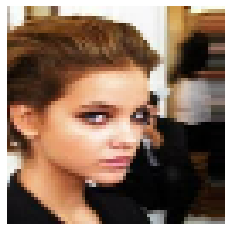

In [41]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

tf.Tensor([[-0.0004984]], shape=(1, 1), dtype=float32)


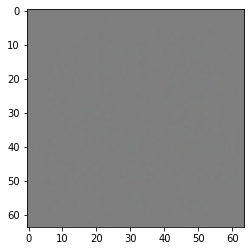

In [62]:
dcgan_model = DCGAN_model_celeb(beta_1_generator=0.3,
                                lr_discriminator=2e-4,
                                lr_generator=4e-4,
                                kernel_size=(7,7),
                                dropout=0.3,
                                beta_1_dicriminator=0.5,
                                folder_prefix="DCGAN_CELEB")

buffer_size = 60000

# Input the noise
noise = tf.random.normal([1, 100])
generated_image = dcgan_model.generator(noise, training=False)

#plt.imshow(generated_image[0, :, :, 0])
plt.imshow((generated_image.numpy() * 127.5 + 127.5).astype("int32")[0])

# input an image to tell if it is a true image
decision= dcgan_model.discriminator(generated_image)
print(decision)  #positive for true and negative for false

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

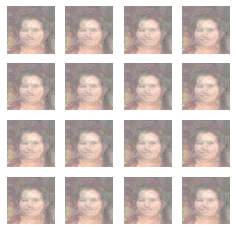

Time for epoch 3 is 1099.7218959331512 sec
Model Name: DCGAN_CELEB_bs32_dr0.3_ks(7, 7)_lrg0.0004_lrd0.0002_b1g0.3_b1d0.5_tdlFalse


In [ ]:
train_model(dcgan_model, dataset, 100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

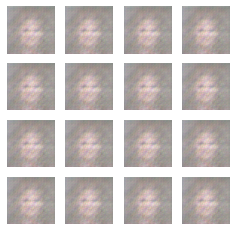

In [89]:
seed = tf.random.normal([num_examples,dim_noise])
save_images(dcgan_model.generator,
            101,
            seed,
            dcgan_model.folder_name)